In [19]:
%matplotlib inline

In [35]:
import os
import wget
import shutil
import torch
import tarfile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from skimage.transform import resize
from skimage import io
from fastprogress import progress_bar
import numpy as np
from skimage.util import img_as_ubyte
from math import sqrt
from train import create_dataloader
import torchvision

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [21]:
if not os.path.exists('data/CUB_200_2011.tgz'):
    wget.download(
        'http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz'
    )

if not os.path.exists('data/CUB_200_2011'):
    shutil.unpack_archive('data/CUB_200_2011.tgz')

data_dir = 'data/CUB_200_2011'
images_dir = os.path.join(data_dir, 'images')

In [22]:
file_images = open(os.path.join(data_dir, 'images.txt'))
file_bboxes = open(os.path.join(data_dir, 'bounding_boxes.txt'))

list_images = file_images.readlines()
list_bboxes = file_bboxes.readlines()

def visualize_image(idx):
    image_path = os.path.join(
        images_dir,
        (list_images[idx].split(' ')[1]).strip('\n')
    )

    image_bbox = list_bboxes[idx].strip('\n').split(' ')
    minc = int(float(image_bbox[1]))
    minr = int(float(image_bbox[2]))
    maxc = int(float(image_bbox[3]))
    maxr = int(float(image_bbox[4]))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(plt.imread(image_path))

    rect = mpatches.Rectangle(
        (minc, minr),
        maxc - minc,
        maxr - minr,
        fill=False,
        edgecolor='green',
        linewidth=2
    )

    ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show();

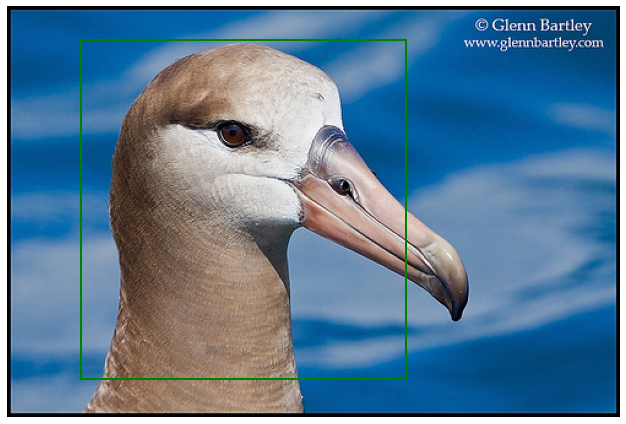

In [23]:
visualize_image(0)

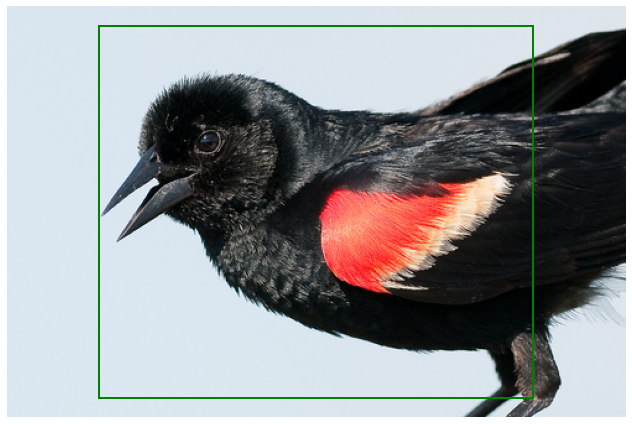

In [24]:
visualize_image(500)

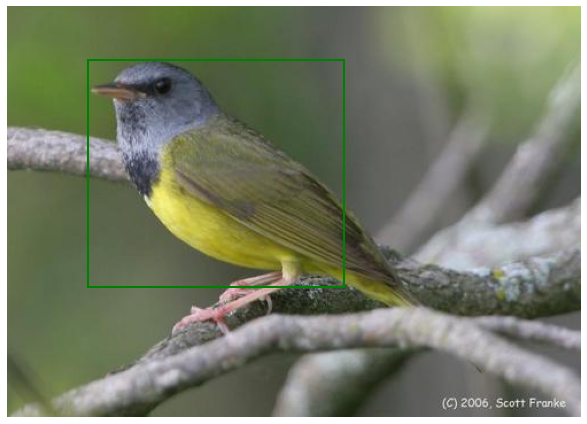

In [25]:
visualize_image(10000)

In [26]:
del file_bboxes
del file_images
del list_bboxes
del list_images

In [27]:
freqs = []
lbls = []
dirs = os.listdir(images_dir)

for directory in dirs:
    dir_pth = os.path.join(images_dir, directory)
    lbls.append(directory)
    freqs.append(len(os.listdir(dir_pth)))

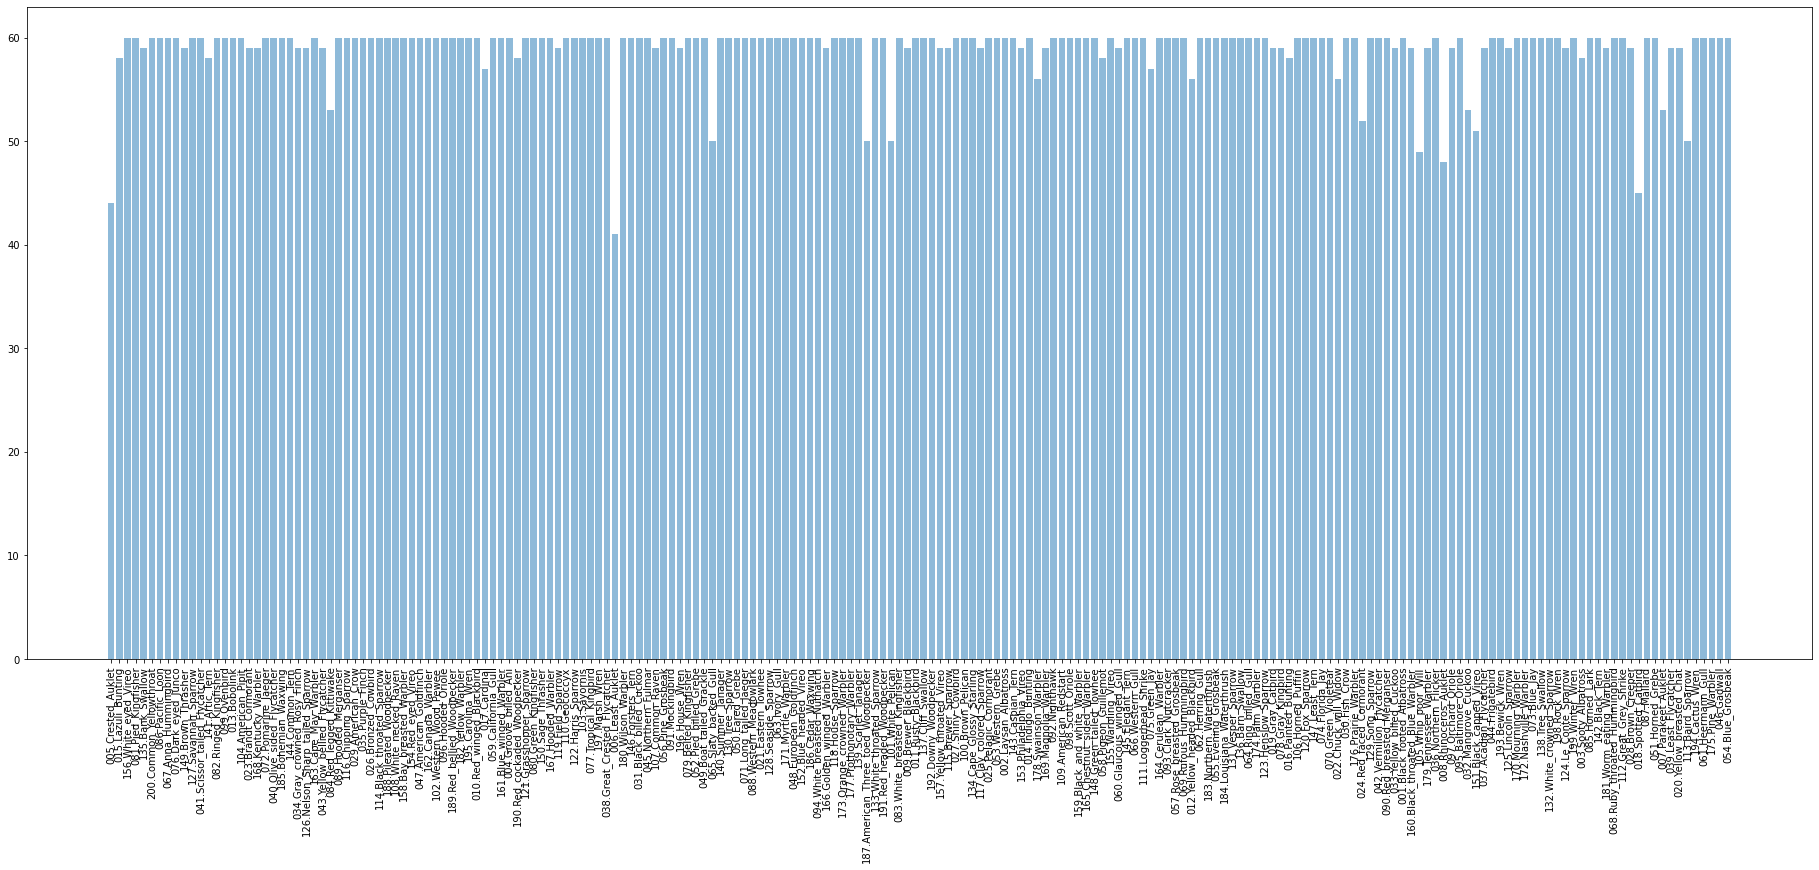

In [29]:
plt.figure(figsize=(32, 12))
y_pos = np.arange(len(lbls))
plt.bar(y_pos, freqs, align='center', alpha=0.5)
plt.xticks(y_pos, lbls, rotation=90)
plt.show();

In [30]:
max_freq = np.max(freqs)
max_freq

60

In [34]:
# global variables
mini_dir = 'data/mini-birds'
bool_minify = True  # change to true
# execute this code only once
if bool_minify:
    if not os.path.exists(mini_dir):
        os.mkdir(mini_dir)
    # first 10 directories
    directories = os.listdir(images_dir)
    # loop sentinent
    loop_counter = 0
    for i, directory in enumerate(directories):
        if loop_counter == 10:
            break
        # bookmark original directory
        source_dir = os.path.join(images_dir, directory)
        # check frequency
        if max_freq > len(os.listdir(source_dir)):
            continue
        else:
            loop_counter += 1
        # bookmark destination directory
        target_dir = os.path.join(mini_dir, directory)
        if not os.path.exists(target_dir):
            os.mkdir(target_dir)
        images_files = os.listdir(source_dir)
        for image_file in progress_bar(images_files):
            image = io.imread(os.path.join(source_dir, image_file))
            new_image = resize(image, (64, 64), anti_aliasing=True)
            # suppress image type warning
            new_image = img_as_ubyte(new_image)
            io.imsave(os.path.join(target_dir, image_file), new_image)

In [40]:
train_loader = create_dataloader(mini_dir, batch_size=128)

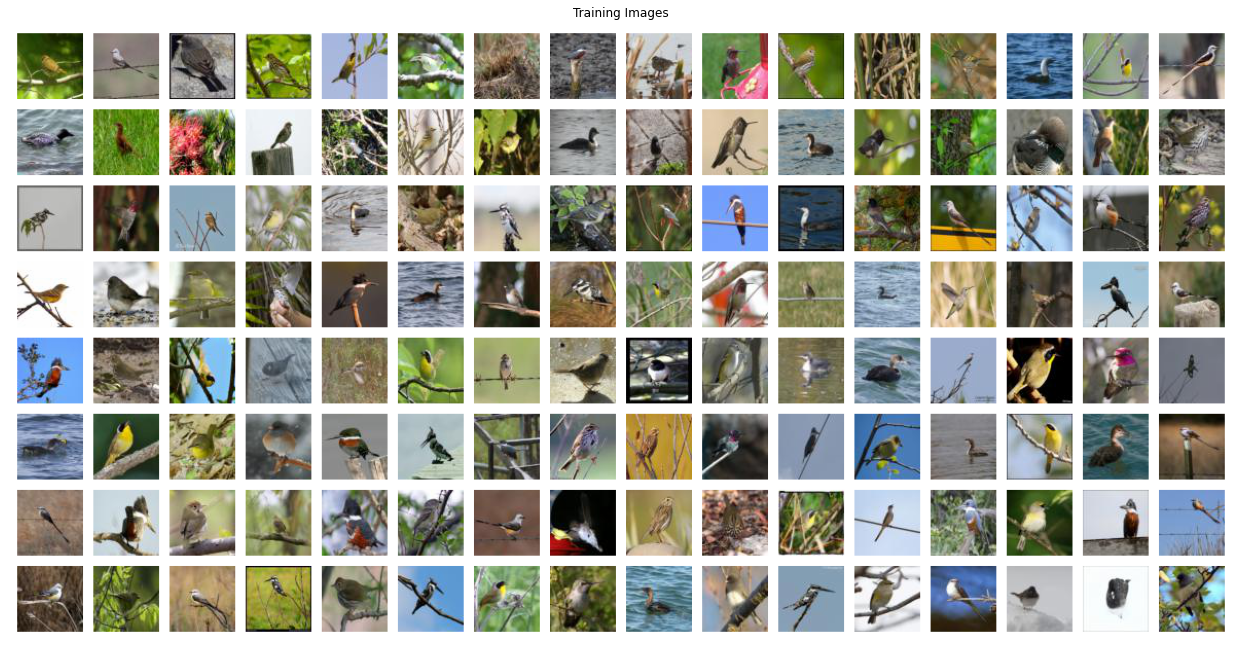

In [44]:
real_batch = next(iter(train_loader))

plt.figure(figsize=(22, 12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            real_batch[0].to(device),
            padding=10,
            normalize=True,
            pad_value=1,
            nrow=int(3 * sqrt(128) / 2)
        ).cpu(),
        (1,2,0)
    )
);